## LoadDataset

In [215]:
from parallel import ParallelExecutor, TaskSpec
import torch
from utils import prepare_dataset
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


之前做了一个实验来判断如果让各weight更orthogonal一点，会不会影响aggregation的结果。
在keras里面只需要使用

```python
tf.keras.regularizers.OrthogonalRegularizer
```

在Pytorch里需要重写trainer 或者 重写一个loss function

##  Trainer

In [216]:
from trainer import DefaultTrainer

class TrainerWithOrthogonalRegularization(DefaultTrainer):
    def __init__(self, factor, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.factor = factor

    def train_step(self, batch):
        self.step += 1
        self.optimizer.zero_grad()
        inputs, targets = batch
        inputs, targets = inputs.to(self.device), targets.to(self.device)
        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        reg_loss = self._orthogonal_regularization_loss()
        total_loss = loss + self.factor * reg_loss
        # the same in DefaultTrainer
        total_loss.backward()
        self.optimizer.step()
        metrics = self.metrics(outputs, targets)
        metrics['loss'] = loss.item()
        metrics['reg_loss'] = reg_loss.item()
        return metrics
        
    
    def _orthogonal_regularization_loss(self) -> torch.Tensor:
        self.linear_layers = [module for module in self.model.modules() if isinstance(module, torch.nn.Linear)]
        ortho_loss = 0.0
        for layer in self.linear_layers:
            weight = layer.weight
            identity = torch.eye(weight.shape[1], device=weight.device)
            ortho_loss += torch.norm(weight.t() @ weight - identity, p='fro')
        return ortho_loss
             
        
    def configure_optimizers(self):
        optimizer = super().configure_optimizers()
        if self.orthogonal_regularization > 0.0:
            optimizer.param_groups[0]['weight_decay'] = 0.0
        return optimizer

In [217]:
from lightning import seed_everything
from utils import prepare_dataset, build_mlp_model
import torchmetrics
import logger
def reg_factor_experiment(factor):
    seed_everything(42)
    # same initialization
    trainset, _ = prepare_dataset("MNIST", "MLP")
    model = build_mlp_model()
    metrics = torchmetrics.MetricCollection(
        [torchmetrics.Accuracy(task='multiclass', num_classes=10),]
    )
    loggers = logger.LoggerCollection(
        [logger.CSVLogger(name=f"factor_{factor}", 
                             saving_dir="different_reg_factors")]
    )
    criterion = torch.nn.CrossEntropyLoss()
    trainer = TrainerWithOrthogonalRegularization(
        factor=factor,
        model=model,
        optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
        criterion=criterion,
        metrics=metrics,
        loggers=loggers,
        device="cuda",
        need_saving=True,
        saving_on='last',
        saving_dir="different_reg_factors/checkpoints",
        saving_name=f"factor_{factor}",
    )
    train_loader = torch.utils.data.DataLoader(trainset, 
                                               batch_size=256, 
                                               shuffle=True)
    results = trainer.fit(train_loader, epochs=30)
    del model
    del trainer
    torch.cuda.empty_cache()
    return results

In [218]:
from parallel import SpecGenerator, TaskSpec

class FactorsSpecGenerator(SpecGenerator):
    def __iter__(self):
        self.factors = [0.0, 1e-4, 1e-3, 1e-2, 1e-1]
        for factor in self.factors:
            yield TaskSpec(
                id=f"factor_{factor}",
                args=(factor,),
                kwargs={},
            )
            
    def __next__(self) -> TaskSpec:
        return next(self.__iter__())

In [219]:
task_spec_generator = FactorsSpecGenerator()
for task_spec in task_spec_generator:
    print(task_spec)

TaskSpec(id='factor_0.0', args=(0.0,), kwargs={})
TaskSpec(id='factor_0.0001', args=(0.0001,), kwargs={})
TaskSpec(id='factor_0.001', args=(0.001,), kwargs={})
TaskSpec(id='factor_0.01', args=(0.01,), kwargs={})
TaskSpec(id='factor_0.1', args=(0.1,), kwargs={})


In [220]:
executor = ParallelExecutor(gpu_fraction=0.3)
executor.run(func=reg_factor_experiment, spec_generator=task_spec_generator)

(reg_factor_experiment pid=2024105) File different_reg_factors/factor_0.001.csv already exists. It will be overwritten.


(reg_factor_experiment pid=2024105) Global seed set to 42
Epoch 0 - loss: 2.2479:   1%|          | 2/235 [00:01<01:59,  1.96it/s]
(reg_factor_experiment pid=2024107) Global seed set to 42 [repeated 4x across cluster]
Epoch 29 - loss: 0.0093: 100%|██████████| 235/235 [00:33<00:00,  6.93it/s]


(reg_factor_experiment pid=2024105) Training Ends
(reg_factor_experiment pid=2024107) File different_reg_factors/factor_0.1.csv already exists. It will be overwritten. [repeated 4x across cluster]
(reg_factor_experiment pid=2024103) Training Results: {'MulticlassAccuracy': tensor(0.9902, device='cuda:0'), 'loss': 0.029102833517529864}


Epoch 29 - loss: 0.0906:  85%|████████▌ | 200/235 [00:29<00:05,  6.83it/s] [repeated 94x across cluster]


(reg_factor_experiment pid=2024104) Training Ends [repeated 2x across cluster]
(reg_factor_experiment pid=2024104) Training Results: {'MulticlassAccuracy': tensor(0.9895, device='cuda:0'), 'loss': 0.03121933072131682} [repeated 2x across cluster]


Epoch 29 - loss: 0.0431:  97%|█████████▋| 227/235 [00:33<00:01,  6.86it/s] [repeated 50x across cluster]


Finished running tasks


[TaskResults(id='factor_0.0', results={'step': 7050, 'train_step_reg_loss': 125.1764144897461, 'train_step_loss': 0.0173956155776977, 'train_step_MulticlassAccuracy': 0.99609375, 'train_epoch_loss': 0.0291028335175298, 'train_epoch_MulticlassAccuracy': 0.9902166724205016}),
 TaskResults(id='factor_0.0001', results={'step': 7050, 'train_step_loss': 0.0131092201918363, 'train_step_MulticlassAccuracy': 0.99609375, 'train_step_reg_loss': 106.46355438232422, 'train_epoch_loss': 0.0312193307213168, 'train_epoch_MulticlassAccuracy': 0.98948335647583}),
 TaskResults(id='factor_0.001', results={'step': 7050, 'train_step_reg_loss': 61.904823303222656, 'train_step_MulticlassAccuracy': 0.9921875, 'train_step_loss': 0.0235855933278799, 'train_epoch_MulticlassAccuracy': 0.9888499975204468, 'train_epoch_loss': 0.0366222638735904}),
 TaskResults(id='factor_0.01', results={'step': 7050, 'train_step_reg_loss': 40.18989562988281, 'train_step_loss': 0.0691303089261055, 'train_step_MulticlassAccuracy': 0.9

In [221]:
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ckpt_paths = os.listdir("different_reg_factors/checkpoints")
dfs = []
for ckpt_path in ckpt_paths:
    name = ckpt_path.split("_")[1]
    ckpt = torch.load(os.path.join("different_reg_factors/checkpoints", ckpt_path))
    csv_path = ckpt['csv_log_path']
    df = pd.read_csv(csv_path)
    df['factor'] = name
    dfs.append(df)
df = pd.concat(dfs)

In [222]:
df.columns

Index(['step', 'train_step_loss', 'train_step_MulticlassAccuracy',
       'train_step_reg_loss', 'train_epoch_loss',
       'train_epoch_MulticlassAccuracy', 'factor'],
      dtype='object')

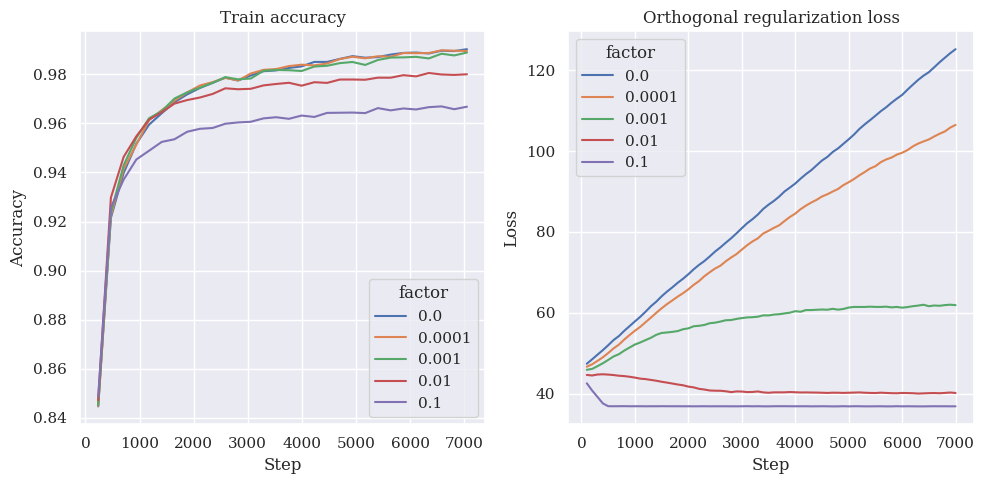

In [227]:
df_reset = df.reset_index()
df_reset.sort_values(by='factor', ascending=True, inplace=True)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
from utils import prepare_sns
prepare_sns()
sns.lineplot(data=df_reset, x='step', 
             y='train_epoch_MulticlassAccuracy', 
             hue='factor', ax=axs[0])
axs[0].set_title("Train accuracy")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Accuracy")
sns.lineplot(data=df_reset, x='step', 
             y='train_step_reg_loss', 
             hue='factor', ax=axs[1])
axs[1].set_title("Orthogonal regularization loss")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Loss")
plt.tight_layout()

看起来只有0.1， 0.001起到了明显的regularization的作用。

现在实验一下有了regularization的模型会对permutation的效果有什么影响。

In [228]:
model_builder = build_mlp_model
def trainer_builder(model):
    return DefaultTrainer(
        model=model,
        optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
        criterion=torch.nn.CrossEntropyLoss(),
        metrics=torchmetrics.MetricCollection(
            [torchmetrics.Accuracy(task='multiclass', num_classes=10),]
        ),
        loggers=logger.LoggerCollection(
            [logger.DummyPrintLogger()]
        ),
        device="cuda",
        need_saving=False,
    )
trainer = trainer_builder(model_builder())

In [229]:
from cgi import test
from typing import Literal, Callable

from sympy import per
def permutation_experiments(
    model_state_dict_1: dict,
    model_state_dict_2: dict,
    model_builder: Callable,
    trainer_builder: Callable,
    testloader: torch.utils.data.DataLoader,
    valloader: torch.utils.data.DataLoader,
    device: Literal['cpu', 'cuda']) -> dict:
    model = model_builder()
    import numpy as np
    alphas = np.linspace(0.0, 1.0, 11)
    results_rows = []
    saving_dir = "different_reg_factors"
    from interpolate import interpolate_weights
    from permute import match_and_permute
    for alpha in alphas:
        interpolated_state_dict = interpolate_weights(model_state_dict_1,
                                                      model_state_dict_2,
                                                      alpha)
        torch.save(
            interpolated_state_dict, 
            os.path.join(saving_dir, f"interpolated_{alpha}.pth")
            )
        model.load_state_dict(interpolated_state_dict)
        # test the interpolted state dict is correct
        test_results = trainer_builder(model).evaluate(testloader)
        results_rows.append({
            "alpha": alpha,
            "test_acc": test_results['MulticlassAccuracy'],
            "test_loss": test_results['loss'],
            "with_matching": False, 
        })
        print("Starts matching and permuting")
        permuted_state_dict_2 = match_and_permute(model_builder=model_builder,
                                                  state_dict_1=model_state_dict_1,
                                                  state_dict_2=model_state_dict_2,
                                                  val_loader=valloader,
                                                  device=device)
        permuted_interpolated_state_dict = interpolate_weights(model_state_dict_1,
                                                               permuted_state_dict_2,
                                                               alpha)
        torch.save(
            permuted_interpolated_state_dict,
            os.path.join(saving_dir, f"permuted_interpolated_{alpha}.pth")
            )
        model.load_state_dict(permuted_interpolated_state_dict)
        test_results = trainer_builder(model).evaluate(testloader)
        results_rows.append({
            "alpha": alpha,
            "test_acc": test_results['MulticlassAccuracy'],
            "test_loss": test_results['loss'],
            "with_matching": True, 
        })
    return results_rows

In [230]:
class ExperimentsSpecsGenerator(SpecGenerator):
    def __iter__(self):
        paths = os.listdir("different_reg_factors/checkpoints")
        factors = [path.split("_")[1] for path in paths]
        ckpts = [torch.load(os.path.join("different_reg_factors/checkpoints", path)) 
                 for path in paths]
        state_dicts = [ckpt['model_state_dict'] for ckpt in ckpts]
        idx = factors.index('0.0')
        base_state_dict = state_dicts.pop(idx)
        factors.pop(idx)
        seed_everything(42)
        _, testset = prepare_dataset("MNIST", "MLP")
        for factor, state_dict in zip(factors, state_dicts):
            testloader = torch.utils.data.DataLoader(testset, batch_size=1000)
            valset = torch.utils.data.Subset(testset, range(100))
            valloader = torch.utils.data.DataLoader(valset, batch_size=1000)
            yield TaskSpec(
                id=f"{factor}",
                args=(base_state_dict, 
                      state_dict,
                      build_mlp_model, 
                      trainer_builder),
                kwargs={
                    'testloader': testloader,
                    'valloader': valloader,
                    'device': 'cuda',
                }
            )

    def __next__(self) -> TaskSpec:
        return next(self.__iter__())
            

In [231]:
task_spec_generator = ExperimentsSpecsGenerator()
executor = ParallelExecutor(gpu_fraction=0.3)
results = executor.run(func=permutation_experiments, 
             spec_generator=task_spec_generator)

Global seed set to 42
  0%|          | 0/10 [00:00<?, ?it/s]375) 


(permutation_experiments pid=2027373) Evaluation Starts


 10%|█         | 1/10 [00:00<00:03,  2.43it/s] 


(permutation_experiments pid=2027373) Step 0: {'test_epoch_MulticlassAccuracy': 0.9815000295639038, 'test_epoch_loss': 0.06942049413919449}
(permutation_experiments pid=2027373) Evaluation Ends
(permutation_experiments pid=2027373) Test Results: {'MulticlassAccuracy': 0.9815000295639038, 'loss': 0.06942049413919449}
(permutation_experiments pid=2027373) Starts matching and permuting


  0%|          | 0/10 [00:00<?, ?it/s] [repeated 7x across cluster]


(permutation_experiments pid=2027373) Evaluation Starts [repeated 8x across cluster]


 90%|█████████ | 9/10 [00:02<00:00,  4.18it/s] [repeated 70x across cluster]


(permutation_experiments pid=2027373) Step 0: {'test_epoch_MulticlassAccuracy': 0.98089998960495, 'test_epoch_loss': 0.06818456202745438} [repeated 8x across cluster]
(permutation_experiments pid=2027373) Evaluation Ends [repeated 8x across cluster]
(permutation_experiments pid=2027373) Test Results: {'MulticlassAccuracy': 0.98089998960495, 'loss': 0.06818456202745438} [repeated 8x across cluster]
(permutation_experiments pid=2027373) Starts matching and permuting [repeated 4x across cluster]


  0%|          | 0/10 [00:00<?, ?it/s] [repeated 8x across cluster]


(permutation_experiments pid=2027373) Evaluation Starts [repeated 8x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.31it/s] [repeated 8x across cluster]


(permutation_experiments pid=2027374) Step 0: {'test_epoch_MulticlassAccuracy': 0.9541000127792358, 'test_epoch_loss': 0.16831550002098083} [repeated 9x across cluster]
(permutation_experiments pid=2027373) Evaluation Ends [repeated 8x across cluster]
(permutation_experiments pid=2027373) Test Results: {'MulticlassAccuracy': 0.9812999963760376, 'loss': 0.07018180191516876} [repeated 8x across cluster]
(permutation_experiments pid=2027373) Starts matching and permuting [repeated 4x across cluster]


  0%|          | 0/10 [00:00<?, ?it/s] [repeated 9x across cluster]


(permutation_experiments pid=2027374) Evaluation Starts [repeated 9x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.25it/s] [repeated 9x across cluster]


(permutation_experiments pid=2027374) Step 0: {'test_epoch_MulticlassAccuracy': 0.9501000046730042, 'test_epoch_loss': 0.17419396340847015} [repeated 8x across cluster]
(permutation_experiments pid=2027374) Evaluation Ends [repeated 9x across cluster]
(permutation_experiments pid=2027374) Test Results: {'MulticlassAccuracy': 0.9501000046730042, 'loss': 0.17419396340847015} [repeated 9x across cluster]
(permutation_experiments pid=2027374) Starts matching and permuting [repeated 5x across cluster]


 30%|███       | 3/10 [00:00<00:01,  4.41it/s] [repeated 73x across cluster]


(permutation_experiments pid=2027376) Evaluation Starts [repeated 9x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.09it/s] [repeated 8x across cluster]


(permutation_experiments pid=2027374) Step 0: {'test_epoch_MulticlassAccuracy': 0.9538999795913696, 'test_epoch_loss': 0.15261207520961761} [repeated 8x across cluster]
(permutation_experiments pid=2027374) Evaluation Ends [repeated 8x across cluster]
(permutation_experiments pid=2027374) Test Results: {'MulticlassAccuracy': 0.9538999795913696, 'loss': 0.15261207520961761} [repeated 8x across cluster]
(permutation_experiments pid=2027374) Starts matching and permuting [repeated 4x across cluster]


 90%|█████████ | 9/10 [00:02<00:00,  4.10it/s] [repeated 75x across cluster]


(permutation_experiments pid=2027376) Evaluation Starts [repeated 8x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.10it/s] [repeated 8x across cluster]


(permutation_experiments pid=2027376) Step 0: {'test_epoch_MulticlassAccuracy': 0.9645000100135803, 'test_epoch_loss': 0.11267407238483429} [repeated 9x across cluster]
(permutation_experiments pid=2027376) Evaluation Ends [repeated 9x across cluster]
(permutation_experiments pid=2027376) Test Results: {'MulticlassAccuracy': 0.9645000100135803, 'loss': 0.11267407238483429} [repeated 9x across cluster]
(permutation_experiments pid=2027376) Starts matching and permuting [repeated 5x across cluster]


 20%|██        | 2/10 [00:00<00:01,  4.22it/s] [repeated 74x across cluster]


(permutation_experiments pid=2027375) Evaluation Starts [repeated 9x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.06it/s] [repeated 8x across cluster]


(permutation_experiments pid=2027375) Step 0: {'test_epoch_MulticlassAccuracy': 0.975600004196167, 'test_epoch_loss': 0.08166434615850449} [repeated 9x across cluster]
(permutation_experiments pid=2027375) Evaluation Ends [repeated 9x across cluster]
(permutation_experiments pid=2027375) Test Results: {'MulticlassAccuracy': 0.975600004196167, 'loss': 0.08166434615850449} [repeated 9x across cluster]
(permutation_experiments pid=2027375) Starts matching and permuting [repeated 5x across cluster]


 90%|█████████ | 9/10 [00:02<00:00,  4.07it/s] [repeated 73x across cluster]


(permutation_experiments pid=2027375) Evaluation Starts [repeated 8x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.36it/s] [repeated 8x across cluster]


(permutation_experiments pid=2027375) Step 0: {'test_epoch_MulticlassAccuracy': 0.9764000177383423, 'test_epoch_loss': 0.07823938131332397} [repeated 8x across cluster]
(permutation_experiments pid=2027375) Evaluation Ends [repeated 8x across cluster]
(permutation_experiments pid=2027375) Test Results: {'MulticlassAccuracy': 0.9764000177383423, 'loss': 0.07823938131332397} [repeated 8x across cluster]
(permutation_experiments pid=2027375) Starts matching and permuting [repeated 4x across cluster]


 90%|█████████ | 9/10 [00:02<00:00,  4.06it/s] [repeated 73x across cluster]


(permutation_experiments pid=2027375) Evaluation Starts [repeated 8x across cluster]


100%|██████████| 10/10 [00:02<00:00,  3.81it/s] [repeated 8x across cluster]


(permutation_experiments pid=2027375) Step 0: {'test_epoch_MulticlassAccuracy': 0.9776999950408936, 'test_epoch_loss': 0.07563120126724243} [repeated 8x across cluster]
(permutation_experiments pid=2027375) Evaluation Ends [repeated 8x across cluster]
(permutation_experiments pid=2027375) Test Results: {'MulticlassAccuracy': 0.9776999950408936, 'loss': 0.07563120126724243} [repeated 8x across cluster]
(permutation_experiments pid=2027375) Starts matching and permuting [repeated 4x across cluster]


 70%|███████   | 7/10 [00:01<00:00,  4.20it/s] [repeated 73x across cluster]


(permutation_experiments pid=2027373) Evaluation Starts [repeated 9x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.23it/s] [repeated 9x across cluster]


(permutation_experiments pid=2027375) Step 0: {'test_epoch_MulticlassAccuracy': 0.9779999852180481, 'test_epoch_loss': 0.07434854656457901} [repeated 8x across cluster]
(permutation_experiments pid=2027375) Evaluation Ends [repeated 8x across cluster]
(permutation_experiments pid=2027375) Test Results: {'MulticlassAccuracy': 0.9779999852180481, 'loss': 0.07434854656457901} [repeated 8x across cluster]
(permutation_experiments pid=2027375) Starts matching and permuting [repeated 4x across cluster]


 80%|████████  | 8/10 [00:01<00:00,  4.13it/s] [repeated 74x across cluster]


(permutation_experiments pid=2027373) Evaluation Starts [repeated 8x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.21it/s] [repeated 8x across cluster]


(permutation_experiments pid=2027375) Step 0: {'test_epoch_MulticlassAccuracy': 0.9789999723434448, 'test_epoch_loss': 0.0747336596250534} [repeated 8x across cluster]
(permutation_experiments pid=2027375) Evaluation Ends [repeated 8x across cluster]
(permutation_experiments pid=2027375) Test Results: {'MulticlassAccuracy': 0.9789999723434448, 'loss': 0.0747336596250534} [repeated 8x across cluster]
(permutation_experiments pid=2027375) Starts matching and permuting [repeated 4x across cluster]


  0%|          | 0/10 [00:00<?, ?it/s] [repeated 6x across cluster]


Finished running tasks


 90%|█████████ | 9/10 [00:02<00:00,  4.03it/s] [repeated 61x across cluster]


(permutation_experiments pid=2027375) Step 0: {'test_epoch_MulticlassAccuracy': 0.9789999723434448, 'test_epoch_loss': 0.0747336596250534}
(permutation_experiments pid=2027375) Evaluation Ends
(permutation_experiments pid=2027375) Test Results: {'MulticlassAccuracy': 0.9789999723434448, 'loss': 0.0747336596250534}


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


In [232]:
results

[TaskResults(id='0.0001', results=[{'alpha': 0.0, 'test_acc': 0.9815000295639038, 'test_loss': 0.06942049413919449, 'with_matching': False}, {'alpha': 0.0, 'test_acc': 0.9815000295639038, 'test_loss': 0.06942049413919449, 'with_matching': True}, {'alpha': 0.1, 'test_acc': 0.98089998960495, 'test_loss': 0.06818456202745438, 'with_matching': False}, {'alpha': 0.1, 'test_acc': 0.9811999797821045, 'test_loss': 0.07017352432012558, 'with_matching': True}, {'alpha': 0.2, 'test_acc': 0.9812999963760376, 'test_loss': 0.07018180191516876, 'with_matching': False}, {'alpha': 0.2, 'test_acc': 0.9797000288963318, 'test_loss': 0.0732424184679985, 'with_matching': True}, {'alpha': 0.30000000000000004, 'test_acc': 0.9799000024795532, 'test_loss': 0.07355441153049469, 'with_matching': False}, {'alpha': 0.30000000000000004, 'test_acc': 0.9789000153541565, 'test_loss': 0.07693783938884735, 'with_matching': True}, {'alpha': 0.4, 'test_acc': 0.9779999852180481, 'test_loss': 0.07648638635873795, 'with_match

In [233]:
rows = []
for result in results:
    factor = result.id
    for result in result.results:
        result['factor'] = factor
        rows.append(result)
rows

[{'alpha': 0.0,
  'test_acc': 0.9815000295639038,
  'test_loss': 0.06942049413919449,
  'with_matching': False,
  'factor': '0.0001'},
 {'alpha': 0.0,
  'test_acc': 0.9815000295639038,
  'test_loss': 0.06942049413919449,
  'with_matching': True,
  'factor': '0.0001'},
 {'alpha': 0.1,
  'test_acc': 0.98089998960495,
  'test_loss': 0.06818456202745438,
  'with_matching': False,
  'factor': '0.0001'},
 {'alpha': 0.1,
  'test_acc': 0.9811999797821045,
  'test_loss': 0.07017352432012558,
  'with_matching': True,
  'factor': '0.0001'},
 {'alpha': 0.2,
  'test_acc': 0.9812999963760376,
  'test_loss': 0.07018180191516876,
  'with_matching': False,
  'factor': '0.0001'},
 {'alpha': 0.2,
  'test_acc': 0.9797000288963318,
  'test_loss': 0.0732424184679985,
  'with_matching': True,
  'factor': '0.0001'},
 {'alpha': 0.30000000000000004,
  'test_acc': 0.9799000024795532,
  'test_loss': 0.07355441153049469,
  'with_matching': False,
  'factor': '0.0001'},
 {'alpha': 0.30000000000000004,
  'test_acc':

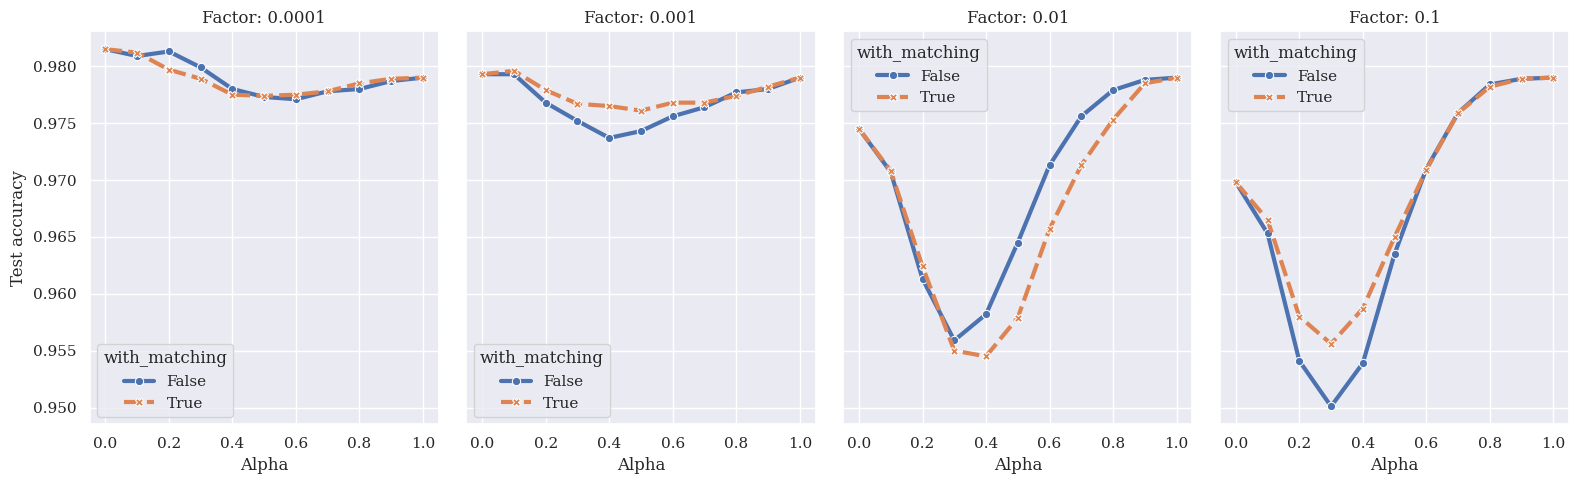

In [241]:
df = pd.DataFrame(rows)
df.sort_values(by=['factor', 'alpha'], inplace=True)
from pyparsing import line
from utils import prepare_sns
prepare_sns()
num_factors = len(df['factor'].unique())
fig, axs = plt.subplots(1, num_factors, figsize=(16, 5), sharey=True)

for i, factor in enumerate(df['factor'].unique()):
    sns.lineplot(data=df[df['factor'] == factor], x='alpha', y='test_acc', 
                 hue='with_matching', ax=axs[i], 
                 linewidth=3, style='with_matching', markers=True,)
    axs[i].set_title(f"Factor: {factor}")
    axs[i].set_xlabel("Alpha")
    axs[i].set_ylabel("Test accuracy")
plt.tight_layout()


显然，在模型差异不大的情况下（0.0001， 0.001）模型直接naive average 效果也不差。
但是在随着正则项factor的增大，naive average的效果也在逐渐变差 （0.01， 0.1）
但是permutation matching 并不是所有时候都有用，比如在factor=0.01的时候，甚至matching之后还差于没有match。
但是总的来说在相同的initialization的情况下，模型聚合起来的的效果都是不错的（0.950~0.98）
比不同的initialization好不少



---

如果non-iid 会怎么影响aggregation的结果呢？

In [264]:
trainset, testset = prepare_dataset("MNIST", "MLP")
subset = torch.utils.data.Subset(trainset, range(500))

In [266]:
len(testset)
labels = [label for _, label in subset] 
# iterating through the test takes much longer than expected
print(labels)

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3, 1, 1, 0, 4, 9, 2, 0, 0, 2, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4, 5, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2, 8, 5, 8, 6, 7, 3, 4, 6, 1, 9, 9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9, 7, 0, 9, 2, 9, 5, 1, 5, 9, 1, 2, 3, 2, 3, 5, 9, 1, 7, 6, 2, 8, 2, 2, 5, 0, 7, 4, 9, 7, 8, 3, 2, 1, 1, 8, 3, 6, 1, 0, 3, 1, 0, 0, 1, 7, 2, 7, 3, 0, 4, 6, 5, 2, 6, 4, 7, 1, 8, 9, 9, 3, 0, 7, 1, 0, 2, 0, 3, 5, 4, 6, 5, 8, 6, 3, 7, 5, 8, 0, 9, 1, 0, 3, 1, 2, 2, 3, 3, 6, 4, 7, 5, 0, 6, 2, 7, 9, 8, 5, 9, 2, 1, 1, 4, 4, 5, 6, 4, 1, 2, 5, 3, 9, 3, 9, 0, 5, 9, 6, 5, 7, 4, 1, 3, 4, 0, 4, 8, 0, 4, 3, 6, 8, 7, 6, 0, 9, 7, 5, 7, 2, 1, 1, 6, 8, 9, 4, 1, 5, 2, 2, 9, 0, 3, 9, 6, 7, 2, 0, 3, 5, 4, 3, 6, 5, 

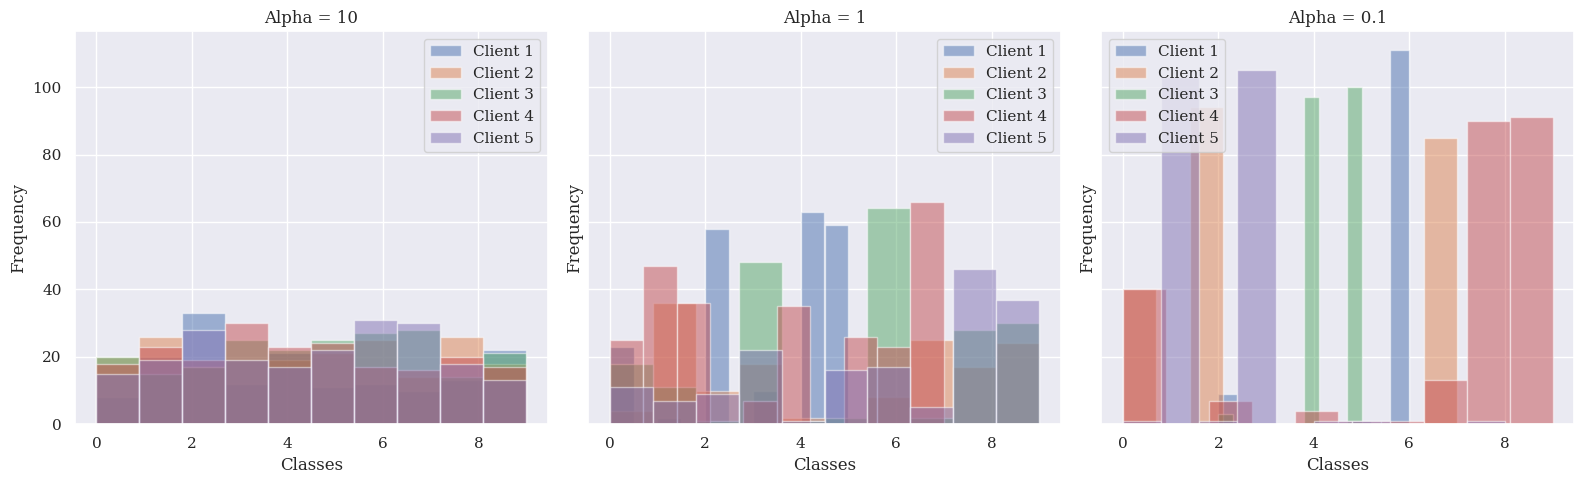

In [263]:
import numpy as np
import matplotlib.pyplot as plt
from split import dirichlet_distribution_noniid_slice

# Assuming 'testset' is your PyTorch test dataset
# Replace this with the actual code to obtain 'labels' from your dataset
labels = np.random.choice(10, 1000)
alphas = [10, 1, 0.1]
num_classes = 10
fig, axs = plt.subplots(1, len(alphas), figsize=(16, 5), sharey=True)

for alpha_idx, alpha in enumerate(alphas):
    idx_slices = dirichlet_distribution_noniid_slice(labels, 5, alpha)

    # Prepare data for histogram
    hist_data = [labels[idx] for idx in idx_slices]

    # Plot histogram for each subset
    for i, subset in enumerate(hist_data):
        axs[alpha_idx].hist(subset, bins=num_classes, alpha=0.5, label=f'Client {i+1}')

    axs[alpha_idx].set_title(f'Alpha = {alpha}')
    axs[alpha_idx].set_xlabel('Classes')
    axs[alpha_idx].set_ylabel('Frequency')
    axs[alpha_idx].legend()

plt.tight_layout()
plt.show()

In [ ]:
from ast import List
from split import dirichlet_distribution_noniid_slice

class NonIIDExperimentsSepcGenerator(SpecGenerator):
    def __init__(self, alphas: List[float]):
        self.num_factors = num_factors

---
